In [30]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import cv2

In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dir = "Dataset/Training"
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Use the true label order
class_names = train_dataset.classes
print("Class order:", class_names)

Class order: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [33]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_dataset.targets),
                                     y=train_dataset.targets)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_dataset.targets),
                                     y=train_dataset.targets)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(class_names)
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
model.train()
for epoch in range(5):
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(pixel_values=inputs)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss:.4f}")

# Save model
torch.save(model.state_dict(), "vit_model.pt")

100%|██████████| 180/180 [01:49<00:00,  1.65it/s]


Epoch 1 Loss: 90.9196


100%|██████████| 180/180 [01:47<00:00,  1.67it/s]


Epoch 2 Loss: 23.3522


100%|██████████| 180/180 [01:50<00:00,  1.63it/s]


Epoch 3 Loss: 13.9372


100%|██████████| 180/180 [01:50<00:00,  1.63it/s]


Epoch 4 Loss: 9.1319


100%|██████████| 180/180 [01:50<00:00,  1.62it/s]


Epoch 5 Loss: 3.0603


 Image: image(71).jpg
 Actual Label      : glioma_tumor
 Predicted Label   : glioma_tumor
 Confidence Score  : 98.97%
 Correct Prediction: True


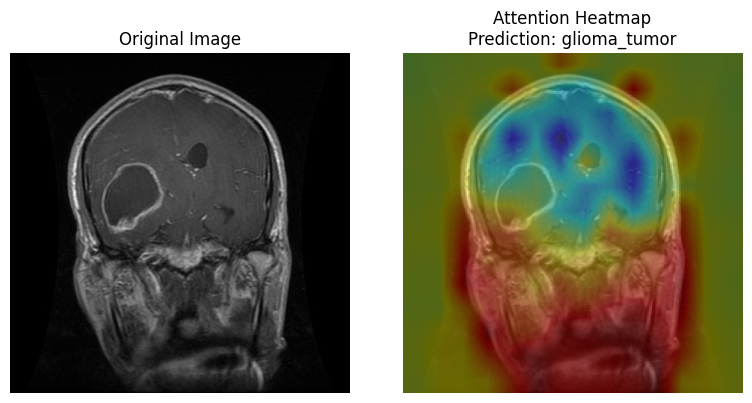

 Image: image(21).jpg
 Actual Label      : meningioma_tumor
 Predicted Label   : meningioma_tumor
 Confidence Score  : 98.68%
 Correct Prediction: True


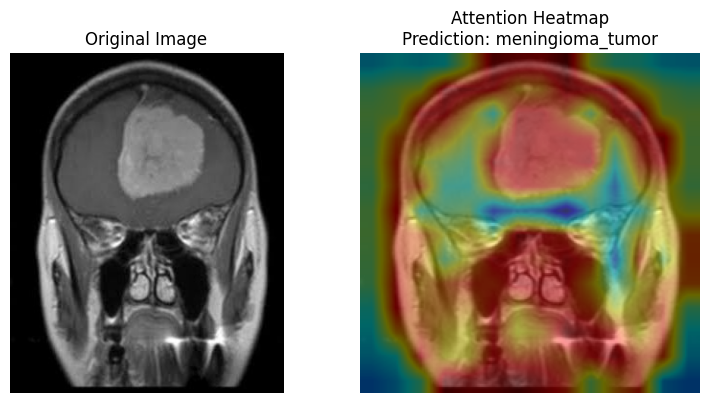

 Image: image(1).jpg
 Actual Label      : pituitary_tumor
 Predicted Label   : meningioma_tumor
 Confidence Score  : 51.13%
 Correct Prediction: False


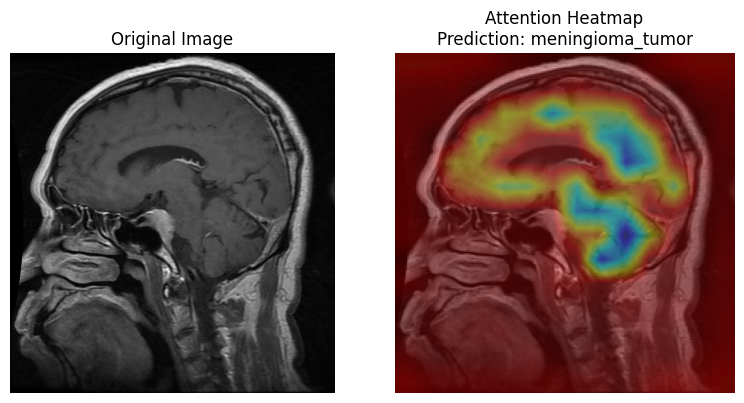

 Image: image(67).jpg
 Actual Label      : no_tumor
 Predicted Label   : no_tumor
 Confidence Score  : 98.84%
 Correct Prediction: True


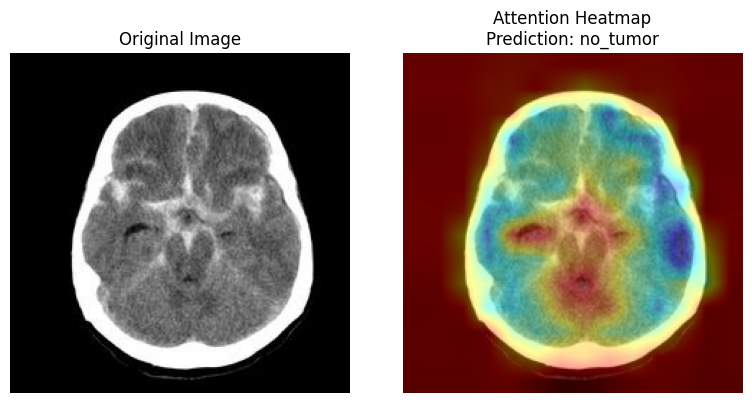

In [ ]:
import random
import glob
import os
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Ensure model is in eval mode
model.eval()

# Include all 4 classes now
target_classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
test_dir = "Dataset/Testing"

# Class name normalization
mapped_class_names = {c.lower().replace(" ", "_"): c for c in class_names}

for tumor_class in target_classes:
    # Get one random image path from the class folder
    class_path = os.path.join(test_dir, tumor_class)
    image_files = glob.glob(os.path.join(class_path, "*.jpg"))
    if not image_files:
        print(f" No images found in: {class_path}")
        continue
    img_path = random.choice(image_files)

    # Load and transform the image
    original_image = Image.open(img_path).convert("RGB")
    image = transform(original_image).unsqueeze(0).to(device)

    # Predict with attention
    with torch.no_grad():
        outputs = model(image, output_attentions=True)

    logits = outputs.logits
    probs = F.softmax(logits, dim=1)
    predicted_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0, predicted_idx].item() * 100
    predicted_label = class_names[predicted_idx]

    # Actual label from folder
    actual_label_folder = os.path.basename(os.path.dirname(img_path)).lower().replace(" ", "_")
    actual_label = mapped_class_names.get(actual_label_folder, "unknown")
    is_correct = predicted_label == actual_label

    # Attention visualization
    attn = outputs.attentions[-1][0].mean(0)[0, 1:].reshape(14, 14).cpu().numpy()
    attn = cv2.resize(attn, (224, 224))
    attn = (attn - attn.min()) / (attn.max() - attn.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * attn), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(original_image.resize((224, 224))), 0.6, heatmap, 0.4, 0)

    # Console Output
    print(f" Image: {os.path.basename(img_path)}")
    print(f" Actual Label      : {actual_label}")
    print(f" Predicted Label   : {predicted_label}")
    print(f" Confidence Score  : {confidence:.2f}%")
    print(f" Correct Prediction: {is_correct}")

    # Show Plot
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Attention Heatmap\nPrediction: {predicted_label}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
